<a href="https://colab.research.google.com/github/FrankGangWang/AppliedML_Python_Coursera/blob/master/Pipelined_Interview_DataScience_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Interview questions to test data science skills**

---




# Let's load the data from public GitHub account

In [5]:
import pandas as pd

# load data
df = pd.read_pickle("https://github.com/manjiler/interview_for_datascience/raw/master/interview_storage.pkl")

# add sorted datetime index
df['timestamp_seconds'] = df.pop('timestamp')/1000
df['Datetime'] = pd.to_datetime(df['timestamp_seconds'], unit='s', origin='unix')
               
df.set_index(df['Datetime'], inplace=True)
df.sort_index(inplace=True)

df.columns

Index(['systemId', 'model_type', 'cpu_utilization', 'read_cache_miss',
       'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput',
       'write_throughput', 'read_iosz', 'write_iosz', 'timestamp_seconds',
       'Datetime'],
      dtype='object')

In [ ]:
# RUN to add some artificial features maybe useful for classification
# add sin/cos for day/hour
# To help finding time periodicity (hourly/daily/weekly/monthly/yearly), 
#    add additional features like "time of day/week" by appling cos and sin to timestamp_seconds 
# time constants in seconds
import numpy as np
hour = 60*60
day = 24*hour
week = 7*day

df['Hour_Sin'] = np.sin(df['timestamp_seconds'] * (2 * np.pi / hour))
df['Hour_Cos'] = np.cos(df['timestamp_seconds'] * (2 * np.pi / hour))
df['Day_Sin'] = np.sin(df['timestamp_seconds'] * (2 * np.pi / day))
df['Day_Cos'] = np.cos(df['timestamp_seconds'] * (2 * np.pi / day))
week_offset = 3*day # as epoch 0 is Thursday 1970-01-01, and leap seconds 23:59:60
df['Week_Sin'] = np.sin((df['timestamp_seconds']+week_offset) * (2 * np.pi / week))
df['Week_Cos'] = np.cos((df['timestamp_seconds']+week_offset) * (2 * np.pi / week))


print(df.head())

print(df.shape, df.index.shape, df.columns)


In [70]:
# pipeline of preprocessing, model
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV

y_column = ['cpu_utilization']
X_columns = list(df.columns.values)
X_columns.remove(y_column[0])
print(type(X_columns), X_columns)

SYSTEM_ID_USED = 'sys1'
MODEL_SINGLE_SYSTEM = True

if MODEL_SINGLE_SYSTEM:
  dftmp = df[df['systemId']==SYSTEM_ID_USED]
  y = dftmp[y_column].copy()
  X = dftmp[X_columns].copy()
else: 
  y = df[y_column].copy()
  X = df[X_columns].copy()


print(f'X.shape = {X.shape}, y.shape={y.shape}')
print(f'X.columns={X.columns}')
print(f'X.head =\n{X.head()}')
print(f'y.head =\n{y.head()}')
print(X.describe().T)


<class 'list'> ['systemId', 'model_type', 'read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz', 'write_iosz', 'timestamp_seconds', 'Datetime', 'Hour_Sin', 'Hour_Cos', 'Day_Sin', 'Day_Cos', 'Week_Sin', 'Week_Cos']
X.shape = (7926, 18), y.shape=(7926, 1)
X.columns=Index(['systemId', 'model_type', 'read_cache_miss', 'write_cache_miss',
       'read_iops', 'write_iops', 'read_throughput', 'write_throughput',
       'read_iosz', 'write_iosz', 'timestamp_seconds', 'Datetime', 'Hour_Sin',
       'Hour_Cos', 'Day_Sin', 'Day_Cos', 'Week_Sin', 'Week_Cos'],
      dtype='object')
X.head =
                    systemId model_type  ...  Week_Sin  Week_Cos
Datetime                                 ...                    
2019-11-01 04:25:00     sys1          A  ... -0.576127 -0.817360
2019-11-01 04:30:00     sys1          A  ... -0.578671 -0.815561
2019-11-01 04:35:00     sys1          A  ... -0.581210 -0.813753
2019-11-01 04:40:00     sys

In [71]:
numeric_features = ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 
                            'read_throughput', 'write_throughput', 'read_iosz', 'write_iosz']

categorical_features = ['systemId', 'model_type']

time_features = [ 'timestamp_seconds', 'Hour_Sin', 'Hour_Cos', 'Day_Sin', 'Day_Cos', 'Week_Sin', 'Week_Cos']

numeric_transformer = Pipeline(
  steps = [
    ('power_transformer', PowerTransformer(method='box-cox', standardize=False)), 
    ('scaler', StandardScaler())
    ]
)

time_transformer = Pipeline(
  steps = [
    ('scaler', StandardScaler())
    ]
)


categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric_transformer', numeric_transformer, numeric_features),
        ('time_transformer', time_transformer, time_features),
        ('categorical_transformer', categorical_transformer, categorical_features)],
        remainder='drop', verbose=False
)

# Append regressor to preprocessing pipeline.
# Now we have a full prediction pipeline.
linear_regressor = Pipeline(
    steps=[
      ('preprocessor', preprocessor),
      #('ridge_regressor', Ridge())
      #('lasso_regressor', Lasso(alpha=0.01))
      ('linear_regressor', LinearRegression())
    ]
)

y_transformer = Pipeline(
  steps = [
    ('power_transformer', PowerTransformer(method='box-cox', standardize=False)), 
    ('scaler', StandardScaler())
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    shuffle=False, random_state=0)

# MUST only train with y_train then transform
y_train_transformed = y_transformer.fit_transform(y_train)
y_test_transformed = y_transformer.transform(y_test)


linear_regressor.fit(X_train, y_train_transformed)

print("model score: %.3f" % linear_regressor.score(X_test, y_test_transformed))
print(f'type(X)={type(X)}, type(y)={type(y)}, type(X_train)={type(X_train)}, type(y_train)={type(y_train)}' )


model score: 0.927
type(X)=<class 'pandas.core.frame.DataFrame'>, type(y)=<class 'pandas.core.frame.DataFrame'>, type(X_train)=<class 'pandas.core.frame.DataFrame'>, type(y_train)=<class 'pandas.core.frame.DataFrame'>


1. w/o power transformer: model score: 0.934
2. w/ power transformer: model scroe: 0.931
3. w/ power transformer and time_transformer: model scroe: 0.933
4. w/ target y transformed,: model score: 0.970


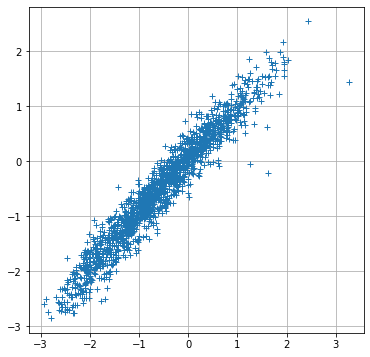

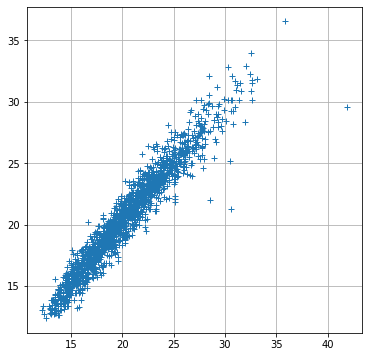

In [72]:
import matplotlib.pyplot as plt
y_predicted = linear_regressor.predict(X_test)

plt.figure()
plt.plot(y_test_transformed, y_predicted, '+')
fig = plt.gcf()
fig.set_size_inches(6, 6)
plt.grid()

y_predicted_inversed = y_transformer.inverse_transform(y_predicted)

plt.figure()
plt.plot(y_test, y_predicted_inversed, '+')
fig = plt.gcf()
fig.set_size_inches(6, 6)
plt.grid()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(y.values, df['cpu_utilization'].values)


In [ ]:
# optional TODO
df['Year'] = df['Datetime'].dt.year  #The year of datetime
df['Month_Of_Year'] = df['Datetime'].dt.month #The month as January=1, December=12
df['Week_Of_Year'] = df['Datetime'].dt.week #The week ordinal of the year
df['Day_Of_Datetime'] = df['Datetime'].dt.day #The days of the datetime
df['Hours_Of_Datetime'] = df['Datetime'].dt.hour #The hours of the datetime
df['Minutes_Of_Datetime'] = df['Datetime'].dt.minute #The minutes of the datetime

# The day of the week with Monday=0, Sunday=6
# TODO: convert the dayofweek into a categorical variable via one-hot encoding
df['Day_Of_Week'] = df['Datetime'].dt.dayofweek  

To avoid data leakage, split df into train set and test set;
1. train set is used for training and cross validation (TimeSeriesSplit)
2. test set is used for final sanity check of model

Design a pipeline that includes all data preparations including 
-- standarization, transformation, normalization
-- feature selection
-- encoding, feature scaling, dimension reduction





In [ ]:
names = ['Year', 'Month_Of_Year', 'Week_Of_Year', 'Day_Of_Datetime',
       'Hours_Of_Datetime', 'Minutes_Of_Datetime', 'Day_Of_Week']
for name in names:
  num = np.unique(df[name])
  print(f'The feature {name} has {len(num)} unique values: {num}')


In [ ]:
#names = ['year', 'month', 'week', 'day', 'hour', 'minute', 'dayofweek']
for name in df.columns.values:
  num = np.unique(df[name])
  print(f'The feature {name} has {len(num)} unique values: {num}')
  if len(num)==1:
    print(f'***** Warning: The feature {name} is deletd as it only has a single unique value {num}')
    del df[name]
df.columns 


In [ ]:
df.head()

In [ ]:
df[df['systemId']=='sys1'].head()

In [ ]:
# Define Constants
import numpy as np
import datetime
import math
import matplotlib.pyplot as plt

SYSTEM_ID_SELECTED = ['sys1'] # ['sys1'] or ['All']
TEST_SIZE = 0.2 # Not yet used
USE_TIME_TRANSFORMED = True 

# We separately process sub-sets of columns and concatenate them in a numpy array called data 
target_col = ['cpu_utilization']
numerical_transform_cols = ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops',
                            'read_throughput', 'write_throughput', 'read_iosz', 'write_iosz']
time_col = ['timestamp_seconds']
time_transformed_cols = ['Week_Sin', 'Week_Cos', 'Day_Sin', 'Day_Cos', 'Hour_Sin', 'Hour_Cos']
cols_to_encode = ['systemId', 'model_type']

#AS timestamp_seconds is appended after numerical_transform_cols are added to data
# As feature selection can be RFE thus standarize/normalize data first;
# Feature selection also cause time poition dymanic thus need be decided after all feature selection
Y_INDEX_DATA = 0 # index of target in data
X_FIRST_INDEX_DATA = 1 # first index in data for X

data_cols = []
df.describe().T

In [ ]:
# Basic checking and basic stats
# check NA for need of imputation
print(f'*** There are {df.isna().sum().sum()} NA data')
print(df.info())
print(df[df['systemId']==SYSTEM_ID_SELECTED[0]].loc[:, ['systemId', 'model_type', 'cpu_utilization']] .tail(5))
print(df[df['systemId']==SYSTEM_ID_SELECTED[0]].loc[:, ['systemId', 'model_type', 'cpu_utilization']] .head(5))


In [ ]:
# Run: check time series's time is continuous or not
# plot timestamp_seconds against target y cpu_utilization;
def plot_time_y(df):
  num_figs= 4
  dftmp = df[df['systemId']==SYSTEM_ID_SELECTED[0]].loc[:, ['timestamp_seconds', 'cpu_utilization']]
  t = df[df['systemId']==SYSTEM_ID_SELECTED[0]].loc[:, ['timestamp_seconds']].values/60
  plt.figure()

  plt.subplot(num_figs,1,1)
  plt.plot( dftmp.index[1:], t[1:], 'g+')
  plt.grid()
  plt.ylabel('time in minutes')

  t = t[1:]- t[0:-1] # time difference
  plt.subplot(num_figs,1,2)
  plt.plot(dftmp.index[1:], t, 'g-+')
  plt.ylabel(f'time interval (minutes)')
  ax = plt.gca()
  ax.legend([f'min={t.min()}, max={t.max()}, mean={t.mean()}'], fontsize='large')
  plt.grid()

  num_days = 7
  stop_index = int(num_days*24*60/5)
  plt.subplot(num_figs,1,3)
  plt.plot(dftmp.index, dftmp['cpu_utilization'].values)
  plt.plot(dftmp.index[:stop_index], dftmp['cpu_utilization'].values[:stop_index], 'g-+')
  plt.ylabel('cpu_utilization')
  plt.grid()

  plt.subplot(num_figs,1,4)
  plt.plot(dftmp.index[:stop_index], dftmp['cpu_utilization'].values[:stop_index], 'g-+')
  plt.ylabel('cpu_utilization')
  ax = plt.gca()
  ax.legend([f'zoomed in above figure'], fontsize='large')
  plt.grid()

  fig = plt.gcf()
  fig.set_size_inches(18.5, num_figs*3)
  fig.suptitle(f'time series check: min interval={t.min()}, max interval={t.max()}')
  plt.tight_layout() # 2nd last step in fig setting
  fig.subplots_adjust(top=0.88) # last in fig setting
  plt.show()


In [ ]:
plot_time_y(df)  

In [ ]:
# plot simple predictor as y[n]=y[n-1] cpu_utilization with decimation by D
def plot_baseline_1step_predictor(D, df, systemId):

  num_figs = 3
  df = df[df['systemId']==systemId[0]].loc[:, ['timestamp_seconds', 'cpu_utilization']]
  L = len(df)

  plt.figure()
  plt.plot( df['cpu_utilization'][0:L-1:D].values, df['cpu_utilization'][1:L:D].values, 'g+')


In [ ]:
plot_baseline_1step_predictor(1, df, SYSTEM_ID_SELECTED)

In [ ]:
# plot y cpu_utilization with decimation by D
def plot_y_decimated(D, df, systemId):
  num_figs = 3
  df = df[df['systemId']==systemId[0]].loc[:, ['timestamp_seconds', 'cpu_utilization']]
  L = len(df)
  plt.figure()
  plt.subplot(num_figs,1,1)
  y_diff = df['cpu_utilization'][1:L:D].values - df['cpu_utilization'][:L-1:D].values

  plt.plot( df.index[1:L:D], df['cpu_utilization'][1:L:D].values, '-+', label='cpu_utilization')
  plt.plot( df.index[1:L:D], y_diff, 'g-+', label='delta cpu_utilization')
  plt.legend()

  plt.subplot(num_figs,1,2)
  plt.plot( df.index[1:L:D], df['cpu_utilization'][0:L-1:D].values, '-+', label='cpu_utilization')
  plt.plot( df.index[1:L:D], df['cpu_utilization'][1:L:D].values, 'g-+', label='lag 1 cpu_utilization')
  plt.legend()

  plt.subplot(num_figs,1,3)
  plt.plot( df.index[1:L:D], 100*y_diff/df['cpu_utilization'][1:L:D].values, '-+', label='cpu_utilization delta in percent')
  plt.legend()

  fig = plt.gcf()
  fig.set_size_inches(18.5, 3*num_figs)
  ax = plt.gca()
  ax.grid()


In [ ]:
D = 1 # decimate by D*5 mins
plot_y_decimated(D, df, SYSTEM_ID_SELECTED)


In [ ]:
df.shape, 

It is not a strict time series data as can be shown with time interval between adjacent samples are not always same (though mostly 5 minutes).
So, it cannot be modelled with ARIMA-like methods.


## Now that the data is loaded. let's begin!!!

# **About the data**

---
This is time series data for one month collected for N number of devices

12 Columns

systemId - Device name

timestamp_seconds - epoch time when the sensor data was collected

model_type - Different versions/release/model of the device (similar to mobile models)

cpu_utilization - this percentage of how much the CPU is used on the device.

read_cache_miss - Percentage of read that were not present in the Cache

write_cache_miss - Percentage of write that were not present in the Cache

read_iops -  Number of read IOs per second (Input/Output)

write_iops -  Nummber of write IOs per second (Input/Output)

read_throughput - the read bandwidth per second (Units kbps)

write_throughput - the write bandwidth per second (Units kbps)

read_iosz - the block size for read Input/Output operations

write_iosz - the block size for write Input/Output operations


y -> cpu_utilization



In [ ]:
df.head()

## Q1. Do an EDA on the data, correlation plots, features that might be important for the modeling. Share your observations. Comment on how the data looks from modeling perspective

In [ ]:
# plot utilities
def plot_corr(df_tmp, systemId_selected):
  import seaborn as sns
  if systemId_selected[0] != 'All':
    df_tmp = df_tmp[df_tmp['systemId']==systemId_selected[0]]
  sns.set_theme(style="white")
  # Compute the correlation matrix
  corr = df_tmp.corr()
  corr_y = corr['cpu_utilization']
  corr_y = corr_y.sort_values(ascending=False)
  f, ax = plt.subplots(figsize=(15, 5))
  corr_y.plot.bar(rot=60)
  print(corr_y)
  
  # Generate a mask for the upper triangle
  mask = np.triu(np.ones_like(corr, dtype=bool))
  # Set up the matplotlib figure
  f, ax = plt.subplots(figsize=(15, 9))
  # Generate a custom diverging colormap
  cmap = sns.diverging_palette(230, 20, as_cmap=True)
  # Draw the heatmap with the mask and correct aspect ratio
  sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
  f.suptitle(f'systemId {systemId_selected[0]}')

In [ ]:
# RUN: plot hist
# Conclusion: a few columns are far from Gaussian distribution
plot_corr(df, SYSTEM_ID_SELECTED)

In [ ]:
# plot histogram of systemId_selected
def plot_df_hist(df_tmp, systemId_selected, title_str, cols, bins):
  if systemId_selected[0] != 'All':
    df_tmp = df_tmp[df_tmp['systemId']==systemId_selected[0]]
  df_tmp = df_tmp[cols]
  df_tmp.hist(bins=bins)
  fig = plt.gcf()
  fig.set_size_inches(18, 8)
  fig.suptitle(f'{title_str}, systemId {systemId_selected[0]}')
  plt.tight_layout()
  fig.subplots_adjust(top=0.9)

# utility hist2d plot xcols against target ycol
def hist2d_plot(df_temp, systemId, xcols, ycol, xbins, ybins, vmax):
  print(f"hist2d_plot 1 Initial address of df_temp: {id(df_temp)}, shape={df_temp.shape}")
  if systemId != 'All': 
    df_temp = df[df['systemId']==systemId[0]]
  print(f"hist2d_plot 2 Initial address of df_temp: {id(df_temp)}, shape={df_temp.shape}")
  print(df_temp.shape)
  len_x = len(xcols)
  num_rows = math.ceil(math.sqrt(len_x))
  num_cols = math.ceil(len_x/num_rows)
  x_index = 0
  for row in range(num_rows):
    for col in range(num_cols):
      if x_index == len_x:
        break
      plt.subplot(num_rows, num_cols, x_index+1)
      plt.hist2d(df_temp[xcols[x_index]], df_temp[ycol], bins=[xbins, ybins], vmax=vmax) #
      plt.colorbar()
      plt.xlabel(xcols[x_index])
      plt.ylabel(ycol)
      x_index = x_index + 1
  fig = plt.gcf()
  fig.set_size_inches(18.5, 3*num_rows)
  fig.suptitle(f'systemId={systemId}')
  plt.tight_layout() # 2nd last step in fig setting
  fig.subplots_adjust(top=0.88) # last in fig setting
  plt.show()


In [ ]:

title_str = 'Before transformation!'
plot_df_hist(df, SYSTEM_ID_SELECTED, title_str, df.columns, 30)
#NOTE: Hour_Sin AND Hour_Cos have only 7 distinct bins at [0, 30, 60, 90, -30, -60, -90] degress as 
# as sampling perid=5 minutes, thus 2pi*5min/60min=pi/6=30degree

The histograms show that we need apply normalization and power transformation


In [ ]:
#Plot hist2d: xcols against target ycol
vmax = 100; xbins = 50; ybins = 50
ycol = 'cpu_utilization'
xcols_group = [
  ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops'],
  ['read_throughput', 'write_throughput', 'read_iosz', 'write_iosz'],
  ['Week_Sin', 'Week_Cos', 'Day_Sin', 'Day_Cos', 'Hour_Sin', 'Hour_Cos']]
for xcols in xcols_group:
  hist2d_plot(df, SYSTEM_ID_SELECTED, xcols, ycol, xbins, ybins, vmax)

# Start preprocessing data: transform to Gaussian, scale, label ategorical featurures and one-hot encode;




In [ ]:
# All pre-processing functions
# Transform to make data more Gaussian-like 
# Standarize to make close Norml(0, 1)
# Only to numerical_transform_cols, not for timestamp, categoricals
def get_target_for_transform(df, systemId_selected, numerical_transform_cols, print_flag=False):
  from sklearn.preprocessing import PowerTransformer
  #from sklearn.preprocessing import QuantileTransformer
  if systemId_selected[0] == 'All':
    df_tmp = df[numerical_transform_cols]
  else:  
    df_tmp = df[df['systemId']==systemId_selected[0]][numerical_transform_cols]
  if print_flag:
    print(f'*** Inside get_target_for_transform(): df_tmp.shape={df_tmp.shape}')
  # Start Transformation
  data = df_tmp.values
  return data

# Transform to make data more Gaussian-like 
# Standarize to make close Norml(0, 1)
# Only to numerical_transform_cols, not for timestamp, categoricals
def transform_features(df, systemId_selected, numerical_transform_cols, print_flag=False):
  from sklearn.preprocessing import PowerTransformer
  #from sklearn.preprocessing import QuantileTransformer
  if systemId_selected[0] == 'All':
    df_tmp = df[numerical_transform_cols]
  else:  
    df_tmp = df[df['systemId']==systemId_selected[0]][numerical_transform_cols]
  # Start Transformation
  data = df_tmp.values
  power = PowerTransformer(method='box-cox', standardize=True)
  data = power.fit_transform(data)
  if print_flag:
    print(f'*** Inside transform_features(): df_tmp.shape={df_tmp.shape}')
    print(f'  transform_features: {power.get_params(deep=True)}')
    print(f'  power.lambdas_: {power.lambdas_}')
  return data, power

# RUN: LabelEncoder + OneHotEncoder for categorical columns
# return np.array oflabel encoded data and encoders
def label_encode(df_in, systemId_selected, cols_to_encode, print_flag=False):
  from sklearn.preprocessing import LabelEncoder
  from sklearn.preprocessing import OneHotEncoder
  if systemId_selected[0] == 'All':
    df = df_in
  else:  
    df = df_in[df_in['systemId']==systemId_selected[0]]
  print(f'inside label_encode: systemId={systemId_selected}, df shape={df.shape}')
  first_col = True
  label_encoders = []
  my_onehot_encoders = []
  for col in cols_to_encode:
    label_encoder = LabelEncoder()
    X = df[col].values
    X = label_encoder.fit_transform(X)
    label_encoders.append({col:label_encoder})
    X = X.reshape(X.shape[0], 1)
    onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
    X = onehot_encoder.fit_transform(X)
    if print_flag:
      print(f'******Inside label_encode: just after my_OneHotEncoder: col={col}, X.shape={X.shape}')
      print(f'******Inside label_encode: just after my_OneHotEncoder: col={col}, onehot_encoder={onehot_encoder}')
    if first_col:
      data = X
      #print(f'first_col={first_col}, col={col}, X.shape={X.shape}, data.shape={data.shape}')
      first_col = False
    else:        
      data = np.concatenate((data, X), axis=1)
      #print(f'first_col={first_col}, col={col}, X.shape={X.shape}, data.shape={data.shape}')
  return data, label_encoders, my_onehot_encoders 

def minmax_scaler_time(df, systemId_selected, cols):
  from sklearn.preprocessing import MinMaxScaler
  if systemId_selected[0] == 'All':
    df_tmp = df[cols].values
  else:  
    df_tmp = df[df['systemId']==systemId_selected[0]][cols].values
  minmax_scaler = MinMaxScaler()
  df_tmp = minmax_scaler.fit_transform(df_tmp)
  return df_tmp

Compare hists of each single systemId ('sys1' vs 'sys2', etc) and single systemId with hist of all systemIds 'All' case:
1. each systemId has different hist patterns
2. Hour_Sin and Hour_Cos show a pattern at certain times per hour


# Apply transforms and extract X, Y, x_cols;


In [ ]:
# RUN: apply transforms to df and extract X, Y, x_cols;

# Step 1: transform AND standarization FOR numerical_transform_cols
# Step 1.1: transform target Y
# MUST first use numerical_transform_cols THEN use cols_to_encode
# MUST NOT transform timestamp_seconds !!! 
from sklearn.preprocessing import PowerTransformer

data_cols = []
data = get_target_for_transform(df, SYSTEM_ID_SELECTED, target_col)
target_transformer = PowerTransformer(method='box-cox', standardize=True)
data = target_transformer.fit_transform(data)
data_cols = data_cols + target_col

print(f'After Y PowerTransformer, data shape={data.shape}, target_col len = {len(target_col)}, data_cols={len(data_cols)}')
print(f'  target_transformer.get_params = : {target_transformer.get_params(deep=True)}')
print(f'  target_transformer.lambdas_= {target_transformer.lambdas_}')

# Step 1.2: transform AND standarization FOR numerical_transform_cols
# MUST first use numerical_transform_cols THEN use cols_to_encode
# MUST NOT transform timestamp_seconds !!! 

print(f'Before X numericals transformation:')
print(f'  data shape = {data.shape}')
print(f'  len of numerical_transform_cols = {len(numerical_transform_cols)}')
data_new, numerical_X_transformer = transform_features(df, SYSTEM_ID_SELECTED, numerical_transform_cols)
data_cols = data_cols + numerical_transform_cols
data = np.concatenate((data, data_new), axis=1)
print(f'After X numericals transformation:')
print(f'  data shape={data.shape}')
print(f'  data_cols len={len(data_cols)},\n  data_cols={data_cols}')


# process timestamp_seconds
print(f'Before add new column {time_col}:\n  data shape={data.shape},\n  len time_col={len(time_col)}')
data_new = minmax_scaler_time(df, SYSTEM_ID_SELECTED, time_col)
data_cols = data_cols + time_col
data = np.concatenate((data, data_new), axis=1)
print(f'After add {time_col}:\n  data shape={data.shape},\n  len data_cols={len(data_cols)}')

# RUN: MinMax timestamp_seconds, not StandardScaler
# timestamp_seconds will be mapped to data[:,9] AND X[:,8]
if USE_TIME_TRANSFORMED:
  data_cols = data_cols + time_transformed_cols
  data_new = minmax_scaler_time(df, SYSTEM_ID_SELECTED, time_transformed_cols)
  print(f'Before add {len(time_transformed_cols)} columns {time_transformed_cols}:\n  data shape={data.shape},\n  data_new shape={data_new.shape}')
  data = np.concatenate((data, data_new), axis=1)
  print(f'After add time_transformed_cols:\n  data shape={data.shape},\n  data_cols ={data_cols}')


# Add label encoder categorical columns (model_type only) (sysemId)
# Note: This is only useful is model all systemIds together;
# WARNING: only run once to avoid add the same columns more than 1 times

data_new, label_encoders, my_onehot_encoders = label_encode(df, SYSTEM_ID_SELECTED, cols_to_encode)
print(f'Before add {len(cols_to_encode)} columns {cols_to_encode}:\n  data shape={data.shape},\n  data_new shape={data_new.shape}')
data = np.concatenate((data, data_new), axis=1)
data_cols = data_cols + cols_to_encode

print(f'After concatenate:\n  data shape={data.shape}')
print(f'  data_cols len={len(data_cols)},\n  data_cols={data_cols}')

X = data[:, X_FIRST_INDEX_DATA:]
Y = data[:, Y_INDEX_DATA]
x_cols = data_cols[1:]


In [ ]:
# Run to check results in good shape 
def check_data_dims():
  dftemp = df[df['systemId']==SYSTEM_ID_SELECTED[0]]
  print(f' df with {SYSTEM_ID_SELECTED} shape = {dftemp.shape}\n')
  del dftemp
  print(f' data.shape = {data.shape}, len(data_cols) = {len(data_cols)}\n')
  print(f' len(x_cols)={len(x_cols)}, X.shape = {X.shape}, Y.shape = {Y.shape}\n')
  print(f' data_cols = {data_cols}, \n x_cols = {x_cols}\n' )
check_data_dims()

Plot ACF and PACF of target cpu_utilization and all numerical features to check correlation in time lags and decide the need of TimeSeriesSplit for strict time series or KFold for iid samples.

Note: the time steps are not always 5 minutes thus the ACF and PACF results shall be carefully read.
May be need imputation???
 

In [ ]:
def plot_y_lag(df, systemId_selected, numerical_transform_cols):
  if systemId_selected[0] != 'All':
    df = df[df['systemId']==systemId_selected[0]][numerical_transform_cols]
  for col in numerical_transform_cols:
    y = df[col]

    values = pd.DataFrame(y.values)
    dataframe = pd.concat([values.shift(2), values.shift(1), values], axis=1)
    dataframe.columns = ['t-2', 't-1', 't']
    result = dataframe.corr()
    print(result)


    plt.plot(y[1:].values, y[0:-1].values, '.')
    plt.figure()
    plt.plot(y[2:].values, y[0:-2].values, '.')



In [ ]:
plot_y_lag(df, ['All'], target_col)


In [ ]:
plot_y_lag(df, ['sys19'], target_col)


By scatter plot of y[n] and y[n-1] for the case of all systemIds, we can see no correlation there.
The y[n] and y[n-1] relationship varies for individual single systemId, e.g. sys11 has strong correlation, but sys12 has weak correlation.
This justifies the need of separate model for prediction for each sytemId separately.
We can use labellled and one-hot encoded systemId as a model feature but this is a cost and add complexity.





In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
def plot_acf_mine(df, systemId_selected, numerical_transform_cols):
  if systemId_selected[0] != 'All':
    df = df[df['systemId']==systemId_selected[0]][numerical_transform_cols]

  for col in numerical_transform_cols:
    plot_acf(df[col])
    plt.title(f'acf of {col} of systemId {systemId_selected[0]}')

    plot_pacf(df[col])
    plt.title(f'pacf of {col} of systemId {systemId_selected[0]}')

    plt.show()


In [ ]:
plot_acf_mine(df, SYSTEM_ID_SELECTED, target_col)


In [ ]:
plot_acf_mine(df, ['All'], target_col)


In [ ]:
plot_acf_mine(df, SYSTEM_ID_SELECTED, numerical_transform_cols)


In [ ]:
df.head()

In [ ]:
plot_acf_mine(df, ['All'], numerical_transform_cols)


In [ ]:
target_col, data_cols.index(target_col[0])
#data_cols.index(target_col)

In [ ]:
print(f'After add {time_col}:\n  data shape={data.shape},\n  len data_cols={len(data_cols)}')
plt.subplot(2,1,1)
plt.plot(data[:, data_cols.index('timestamp_seconds')])
plt.subplot(2,1,2)
plt.plot(data[:, data_cols.index('timestamp_seconds')], data[:, data_cols.index(target_col[0])])


In [ ]:
# check time transformations are all right
plt.figure()
index_to_plots = [1,3,5,7,8]
L = len(index_to_plots)
for k in range(L):
  plt.subplot(L,1,k+1)
  plt.plot(data[:, data_cols.index('timestamp_seconds')], data[:, data_cols.index('timestamp_seconds') + index_to_plots[k]],)


In [ ]:
# Compare hist before/after transformation/scaling 
# Before transformation: hist
title_str = 'Before transformation!'
plot_df_hist(df, SYSTEM_ID_SELECTED, title_str, df.columns, 30)
#NOTE: Hour_Sin AND Hour_Cos have only 7 distinct bins at [0, 30, 60, 90, -30, -60, -90] degress as 
# as sampling perid=5 minutes, thus 2pi*5min/60min=pi/6=30degree

# After transformation: hist
title_str = 'After transformation!'
data_df = pd.DataFrame(data, columns=data_cols)
plot_df_hist(data_df, ['All'], title_str, data_df.columns, 30)
del data_df

Feature selection:
1. correlation based
2. L1 norm
3. p-value

In [ ]:
# RUN: feature selection based on correlation  
# NOTE: this is done separately for each of systemId, not for all systemIds altogether
#label encoder for model
def select_feature_by_correlation(data, data_cols, target_col, corr_threshold):
  df = pd.DataFrame(data, columns=data_cols)
  corr = df.corr()
  columns = np.full((corr.shape[0],), True, dtype=bool)
  for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
      if corr.iloc[i,j] >= corr_threshold:
        columns[j] = False
  selected_columns = df.columns[columns]
  removed_columns = [x for x in df.columns if x not in selected_columns]

  print(f'df shape={df.shape}; corr shape={corr.shape};')
  print(f'df.columns={df.columns}')
  print(f'columns={columns}')
  print(f'selected_columns={selected_columns}')
  print(f'removed_columns={removed_columns}')
  return selected_columns, removed_columns, corr



In [ ]:
# RUN: feature selection based on correlation  
CORR_THRESHOLD_FEATURE_SELECTION = 0.8;
pd.set_option('display.max_columns', None)

#corr of X
selected_columns, removed_columns, corr_X = select_feature_by_correlation(X, x_cols, target_col, CORR_THRESHOLD_FEATURE_SELECTION)    


In [ ]:
# corr of data
_, _, corr_data = select_feature_by_correlation(data, data_cols, target_col, CORR_THRESHOLD_FEATURE_SELECTION)    

In [ ]:
# plot 'read_throughput', 'read_cache_miss'
cols_correlated = ['read_throughput', 'read_cache_miss', 'read_iops', 'write_iops']
cols_correlated_index = [data_cols.index(x) for x in cols_correlated]

print(len(data_cols), data.shape)
print(cols_correlated_index, data_cols)
plt.figure()
plt.plot(data[:, cols_correlated_index[0]], data[:, cols_correlated_index[1]], '+')

plt.figure()
plt.plot(data[:, cols_correlated_index[0]], data[:, cols_correlated_index[2]], '+')

plt.figure()
plt.plot(data[:, cols_correlated_index[0]], data[:, cols_correlated_index[3]], '+')

plt.figure()
plt.plot(data[:, cols_correlated_index[2]], data[:, cols_correlated_index[3]], '+')


In [ ]:
# make a regression prediction with an RFE pipeline
# Observation: Features are selected almost according to their correlation with target
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
# create pipeline
for num_features in range(2,17):
  rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=num_features)
  #model = DecisionTreeRegressor()
  #pipeline = Pipeline(steps=[('s',rfe),('m',model)])
  # fit the model on all available data
  #pipeline.fit(X, Y)
  rfe.fit(X, Y)
  scores = rfe.score(X, Y)
  selected_features = rfe.get_support(indices=True)
  print(num_features, selected_features, scores)
  selected_feature_str = [x_cols[x] for x in selected_features]
  print(f'  {selected_feature_str}')
  #print(f"  {corr_data.loc[selected_feature_str, target_col[0]]}")


In [ ]:
# Start RFE feature selection; 
# Input: X, Y, num_features_to_select
NUM_SPLITS = 10

num_features_to_select = [12,13]
# evaluate RFE for regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold

# get a list of models to evaluate
def get_models():
	models = dict()
	for i in range(num_features_to_select[0], num_features_to_select[1]):
		rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=i)
		model = DecisionTreeRegressor()
		models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
	return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
  #cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  kfold = KFold(n_splits = NUM_SPLITS) # shuffle=False
  scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', 
                           cv=kfold, n_jobs=-1, error_score='raise')
  return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
  scores = evaluate_model(model, X, Y)
  results.append(scores)
  names.append(name)
  print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
  #print(model.support_, model.ranking_)
  print(model)
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()


Observation:
1. read_throughput and read_cache_miss are highly correlated (0.862791);
2. model_type and systemId are unrelated in case of single case systemId
3. timestamps not contribute much
4. transfomred times have some correlation with a few columns



In [ ]:
removed_columns = removed_columns + ['model_type', 'systemId']
removed_columns

In [ ]:
def remove_data_columns(data, data_cols, removed_columns):
  data_index_remove = [data_cols.index(x) for x in removed_columns]
  print(f'data_index_remove = {data_index_remove}')
  data = np.delete(data, data_index_remove, axis=1)
  data_cols_updated = [ x for x in data_cols if x not in removed_columns]
  print(data.shape, len(data_cols_updated), data_cols_updated)
  return data_cols_updated, data  


In [ ]:
# WARNING: only run this ONCE
data_cols, data = remove_data_columns(data, data_cols, removed_columns)


**Observation** 
After comparison Correlation plots of two cases:
-- Case_SINGLE: Only extract a single systemId (here 'sys1') case; 
-- Case_ALL:  Use all systemIds as a whole;

Conclusion:
1. timestamp_seconds has low correlation with all the rest features; and is less useful directly;
2. Day_Cos and Day_Sin have good correlation with a few columns and shall help prediction;


Case_SINGLE clearly exposes a larger nuber of columns having high correlations with the target 'cpu_utilization' than  that of Case_ALL. 

1.1 columns having good correlation with 'cpu_utilization':
Case_SINGLE: ['write_throughput', 'write_iops', 'read_cache_miss', 'read_throughput', 'read_iops', 'write_cache_miss']

Case_ALL: ['read_throughput', 'read_cache_miss'] 
['write_cache_miss',  'read_iops', 'write_throughput', 'write_iosz' ]

1.1 columns having good correlation with Day_sin:  
Case_SINGLE ['write_cache_miss', 'read_iops', 'write_iosz' ]
Case_ALL: None

1.2 Day_Cos has good correlation with 2 columns:
Case_SINGLE: ['write_iops', 'read_iosz']
Case_ALL: None





In [ ]:
# check outliers; conclusion: no apparent outliers
df_stat = df.describe().T
df_stat['50% to 75%'] = (df_stat['50%']/df_stat['75%'])
df_stat['max to 75%'] = (df_stat['max']/df_stat['75%'])


In [ ]:
# RUN: backwardElimination
import statsmodels.api as sm
def backwardElimination(x, Y, sl, columns):
    print(f'x={x[:2,:]}')
    print(f'Y={Y[:2]}')
    print(f'len(x[0]) = {len(x[0])}')
    print(f'x shape = {x.shape}')

    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
        print(f'**** backwardElimination i={i}, p-values={regressor_OLS.pvalues}')
        print(f'inside loop: x shape = {x.shape}')
                    
    print(regressor_OLS.summary())
    return x, columns


In [ ]:
SL = 0.05
data_modeled, selected_columns = backwardElimination(X, Y, SL, selected_columns)

## Q2. Group on systemId and one week's duration and then calculate following custom metrics
- std/median on columns read_iops, read_cache_miss
- rolling mean on columns write_throughput and write_iosz
- exponential moving average on column write_cache_miss and write_iops


In [ ]:
check_data_dims()

In [ ]:
features = [['systemId', 'read_iops', 'read_cache_miss'],
            ['systemId', 'write_throughput', 'write_iosz'],
            ['systemId', 'write_cache_miss', 'write_iops']]



In [ ]:
dftemp = df[['systemId', 'read_iops', 'read_cache_miss']]
metrics = []
metrics_sum = dftemp.groupby('systemId').resample('W').sum()
metrics_std = dftemp.groupby('systemId').resample('W').std()
metrics_std = dftemp.groupby('systemId').resample('W').median()


In [ ]:
type(metrics_sum.index.values)



In [ ]:
print(metrics_sum.index.values.shape)
print(type(metrics_sum.index.values))
print(type(metrics_sum.index.values[0]))
print(type(metrics_sum.index.values[0][0]))

print(metrics_sum.index.values.shape)
print(metrics_sum.index.values[0])
print(metrics_sum.index.values[:10][0])

     


In [ ]:
print(metrics_sum.index.values[:10][:][:][0])


In [ ]:
dftemp = df[['systemId', 'read_iops', 'read_cache_miss']]
metrics = []
metrics.append(dftemp.groupby('systemId').resample('W').sum())
metrics.append(dftemp.groupby('systemId').resample('W').std())
metrics.append(dftemp.groupby('systemId').resample('W').median())


In [ ]:
metrics[2]['read_iops'].plot(subplots=True)

In [ ]:
metrics[2].index.names
 



In [ ]:
metrics_sum

In [ ]:

dftemp = df[['systemId', 'read_iops', 'read_cache_miss']]
df_grouped = dftemp.groupby('systemId')

ct = 0
for group_name, df_group in df_grouped:
  ct = ct + 1
  if ct>5: 
    break

  print(f'\n\n ****** ct={ct}, {group_name} , shape={df_group.shape}****') 
  #print(df_group.index)
  #print(df_group.head())

  stat = df_group.resample('W', origin='start').median()
  # rename columns
  stat.columns = [group_name+'_read_iops_median', group_name+'_read_cache_miss_median']
  #reset index to get grouped columns back
  #stat = stat.reset_index()

  print(f'\n ****** {group_name} mean, shape={stat.shape}, stat type ={type(stat)}****') 
  print(stat)

  if ct==1:
    df_merged = stat
  else:        
    df_merged = pd.concat([df_merged, stat], axis=1) #ignore_index=True, 

  print(f'\n ****** {group_name} mean, df_merged shape={df_merged.shape}, df_merged columns ={df_merged.columns}****') 
  print(f'**************** df_merged=\n{df_merged}')


In [ ]:
features = ['systemId','read_iops', 'read_cache_miss'] #, 'write_throughput', 'write_iosz', 'write_cache_miss', 'write_iops']
dftemp = df[features]
df_grouped = dftemp.groupby('systemId')


In [ ]:
df_grouped.head()

In [ ]:
type(df_grouped)

In [ ]:
df_grouped

In [ ]:
len(df_grouped)


In [ ]:
for x in df_grouped:
  print(x)

In [ ]:
check_data_dims()

In [ ]:
def make_metrics_std_median(X, x_cols, std_median_cols, print_flag=False):
  print(f' *** Inside make_metrics_std_median(): systemId={systemId_selected}, df shape={df.shape}')



  df1[f] = df1[f].rolling(window=Window_Length).mean()

# Run to add metrics
std_median_cols = ['read_iops', 'read_cache_miss']
make_metrics_std_median(X, x_cols, std_median_cols, True)


In [ ]:
features = [['read_iops', 'read_cache_miss'],
            ['write_throughput', 'write_iosz'],
            ['write_cache_miss', 'write_iops']]

for k in range(len(features)):
  print(features[k])
  for x in features[k]:
    print(x)


dftemp = df[['systemId', 'read_iops', 'read_cache_miss']]
df_grouped = dftemp.groupby('systemId')

ct = 0
for group_name, df_group in df_grouped:
  ct = ct + 1
  if ct>2: 
    break
  
  df_group = df_group.sort_index()

  print(f'\n\n ****** {group_name} , shape={df_group.shape}****') 
  print(df_group.head())

  stat = df_group.resample('W', origin='start').sum()
  print(f'\n ****** {group_name} sum, shape={stat.shape}****') 
  print(stat)

  stat = df_group.resample('W', origin='start').median()
  print(f'\n ****** {group_name} median, shape={stat.shape}****') 
  print(stat)
    
  stat = df_group.resample('W', origin='start').std()
  print(f'\n ****** {group_name} std, shape={stat.shape}****') 
  print(stat)

In [ ]:
print(X.shape, len(x_cols))


In [ ]:

# normalize, average, and plot
def plot_columns_average(df, AVERAGE_METHOD, Window_Length):
  df1 = df[df['systemId']=='sys1']

  start_hour = 24*1+15;
  interval_hour= 24*20 + 10
  start = int(start_hour*hour/(5*60))
  stop = int((start_hour + interval_hour)*hour/(5*60))

  for f in cols_to_avg:
    if AVERAGE_METHOD == 'rolling_moving_average':
      df1[f] = df1[f].rolling(window=Window_Length).mean()
    elif AVERAGE_METHOD == 'exponential_moving_average':
      df1[f] = df1[f].ewm(span=Window_Length, adjust=False).mean()
    elif AVERAGE_METHOD == 'cumulative_average': 
      df1[f] = df1[f].expanding(min_periods=Window_Length, adjust=False).mean()
    else:
      raise ValueError(f'AVERAGE_METHOD ={AVERAGE_METHOD} is not implemented!')
        
Window_Length = int(2*60/5) 

AVERAGE_METHOD_LIST = ['rolling_moving_average', 'exponential_moving_average', 'cumulative_average']
AVERAGE_METHOD = AVERAGE_METHOD_LIST[1] 
plot_columns_average(df, AVERAGE_METHOD, Window_Length)


In [ ]:
group = group.sort_values(by='timestamp_seconds')
group.head(8)tmp = group.rolling(2).mean()
tmp.head(8)

group['rmean_write_throughput'] = tmp['write_throughput']
group['rmean_write_iosz'] = tmp['write_iosz']
group.head(8)

In [ ]:
# fft plot TODO: for time ordered and single systemId 
def plot_fft(df_in, col_choice):
  import tensorflow as tf
  df = df_in[df_in['systemId']==SYSTEM_ID_SELECTED[0]]
  fft = tf.signal.rfft(df[col_choice])
  f_per_dataset = np.arange(0, len(fft))
  print(f'df.shape={df.shape}, fft.shape={fft.shape}')
  n_samples_h = len(df[col_choice])
  plt.plot(f_per_dataset, np.abs(fft), '-+')
  #plt.xscale('log')
  plt.ylim(0, np.mean(np.abs(fft))*10)
  plt.xlim([0.1, max(plt.xlim())])
  _ = plt.xlabel('Frequency (log scale)')
  plt.grid()


In [ ]:
plot_fft(df, 'cpu_utilization')


In [ ]:
plot_fft(df, 'read_throughput')

In [ ]:
plot_fft(df, 'write_throughput')

In [ ]:
plot_fft(df, 'Hour_Cos')


In [ ]:
plot_fft(df, 'Day_Cos')
7966/24/12

In [ ]:
plot_fft(df, 'Week_Cos')


In [ ]:

if 0:
  summary = []
  for name, group in group_by_systemId:
    summary.append(
      {
        name : 
          {
            'length': len(group),
            'min': group['read_iops'].min(),
            'max': group['read_iops'].max(),
            'mean': group['read_iops'].mean(),
            'std': group['read_iops'].std(),
            'median': group['read_iops'].median()
          }
      }
    )
  if 0:
    print(f'name={name}, len = {len(group)}\n')
    print('systemId uniques=', np.unique(group['systemId']))
    #print(f'group={group.head(2)}\n')
    print(f'summary={summary}')


## Q3. Generate a random distribution of samples from data such that each day should contain 12 continous samples and start of the sample should be random with that day

In [ ]:
check_data_dims()

## Q4. Fit a linear regression to this data with y as "cpu_utilization" column. Comment on the fit of the model

TODO: 
1. reserve a common test set for comparison scores like mse
(time continuity ???)
2. define a baseline model simply y[n]=y[n-1]
3. Linear Regression, Ridge, Lasso with Grid Search
4. GradientBoost, XGBoost


In [ ]:
check_data_dims()

In [ ]:
# First define a baseline prediction model as y[n] = y[n-1];
# There are a few discontinuity points which can be ignored.

# persistence model
def model_persistence(x):
	return x

def baseline_timeseries_predictor_y(Y):
  values = pd.DataFrame(Y)
  from pandas import concat
  from sklearn.metrics import mean_squared_error

  # Create lagged dataset
  dataframe = concat([values.shift(1), values], axis=1)
  dataframe.columns = ['t-1', 't']
  print(dataframe.head(5))

  # time series is split into train and test sets
  X = dataframe.values
  train_size = int(len(X) * 0.66)
  train, test = X[1:train_size], X[train_size:]
  train_X, train_y = train[:,0], train[:,1]
  test_X, test_y = test[:,0], test[:,1]

  # walk-forward validation
  predictions = list()
  for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)

  test_score = mean_squared_error(test_y, predictions)

  print('Test MSE: %.3f' % test_score)

  # plot predictions and expected results
  stop_idx = 100 #len(test_y)
  plt.figure()
  plt.plot(test_y[:stop_idx], 'r-+')
  plt.plot(predictions[:stop_idx], 'g-o')
  fig = plt.gcf()
  fig.set_size_inches(22.5, 3)

  stop_idx = 100 #len(test_y)
  plt.figure()
  plt.plot(test_y[:stop_idx], 'r-+')
  plt.plot(test_y[:stop_idx] - predictions[:stop_idx], 'g-o')
  fig = plt.gcf()
  fig.set_size_inches(22.5, 3)

  plt.figure()
  plt.plot(test_y, predictions, 'r+')
  fig = plt.gcf()
  fig.set_size_inches(10, 10)


In [ ]:
baseline_timeseries_predictor_y(Y)

In [ ]:
def RFE_timelagged_y(dataframe):
  from sklearn.feature_selection import RFE
  from sklearn.ensemble import RandomForestRegressor
  from matplotlib import pyplot
  array = dataframe.values
  X = array[:,0:-1]
  y = array[:,-1]
  # perform feature selection
  rfe = RFE(RandomForestRegressor(n_estimators=500, random_state=1), n_features_to_select=4)
  fit = rfe.fit(X, y)
  # report selected features
  print('Selected Features:')
  names = dataframe.columns.values[0:-1]
  for i in range(len(fit.support_)):
    if fit.support_[i]:
      print(names[i])
  # plot feature rank
  names = dataframe.columns.values[0:-1]
  ticks = [i for i in range(len(names))]
  pyplot.bar(ticks, fit.ranking_)
  pyplot.xticks(ticks, names)
  pyplot.show()

Selected Features:
t-6
t-3
t-2
t-1

In [ ]:
df.shape

In [ ]:
# create num_lags number of new columns of shifted observations
def baseline_timeseries_multilags_y(Y, num_lags, rolling_window_widths, ewm_alphas):
  from sklearn.linear_model import LinearRegression
  values = pd.DataFrame(Y)
  from sklearn.metrics import mean_squared_error

  # Create lagged dataset
  dataframe = pd.DataFrame()
  for i in range(num_lags+1):
    dataframe['t-'+str(i)] = values.shift(i).values[:,0]

  if len(rolling_window_widths)>0:
    for rolling_window in rolling_window_widths:
      # temp solution: add rolling before target y as rolling mean of t-1 as we extract y as last column later
      dataframe['rolling std '+str(rolling_window)] = dataframe['t-1'].rolling(window=rolling_window).std()
      dataframe['rolling mean '+str(rolling_window)] = dataframe['t-1'].rolling(window=rolling_window).mean()
  if len(ewm_alphas)>0:
    for alpha in ewm_alphas: 
      dataframe['ewm_mean '+str(alpha)] = dataframe['t-1'].ewm(alpha=alpha).mean()
      dataframe['ewm_std '+str(alpha)] = dataframe['t-1'].ewm(alpha=alpha).std()

  #print(dataframe.head(num_lags+1))
  ignored_nans = max(num_lags, len(rolling_window_widths), )
  dataframe = dataframe[ignored_nans+1:]
  dataframe.head(10)
  return dataframe

In [ ]:
def LinearRegression_mse(dataframe):
  from sklearn.metrics import mean_squared_error
  from sklearn.linear_model import LinearRegression 

  #X = dataframe.values
  train_size = int(len(dataframe) * 0.66)
  train_y = dataframe.iloc[:train_size, 0].values
  train_X = dataframe.iloc[:train_size, 1:].values

  test_y = dataframe.iloc[train_size:, 0].values
  test_X = dataframe.iloc[train_size:, 1:].values

  train_y = train_y.reshape(train_y.shape[0], 1)
  test_y = test_y.reshape(test_y.shape[0], 1)

  print(f'**** train_X shape = {train_X.shape}, test_X shape = {test_X.shape}')
  print(f'**** train_y shape = {train_y.shape}, test_y shape = {test_y.shape}')

  model = LinearRegression()
  model.fit(train_X, train_y)
  predictions = model.predict(test_X)
  test_score = mean_squared_error(test_y, predictions)

  if 0:
    print(type(train_X), type(train_y))
    print(train_X.shape, train_y.shape)
    print(test_X.shape, test_y.shape)
    print(f'type model.coef_={type(model.coef_)}')
  
  print(f'model.coef_={model.coef_}')
  print('Test MSE: %.3f' % test_score)  
  print(f'model.coef_ shape={model.coef_.shape}, columns = {dataframe.columns[1:]}')

  plt.figure()
  model.coef_ = model.coef_.reshape(model.coef_.shape[1],)
  plt.plot(dataframe.columns[1:], model.coef_, 'r-o')
  plt.title('model coef')
  plt.xticks(rotation = 60)
  plt.grid()
  fig = plt.gcf()
  fig.set_size_inches(22.5, 3)

  # plot predictions and expected results
  stop_idx = 100 #len(test_y)
  plt.figure()
  plt.plot(test_y[:stop_idx], 'r-+')
  plt.plot(predictions[:stop_idx], 'g-o')
  fig = plt.gcf()
  fig.set_size_inches(22.5, 3)

  stop_idx = 100 #len(test_y)
  plt.figure()
  plt.plot(test_y[:stop_idx], 'r-+')
  plt.plot(test_y[:stop_idx] - predictions[:stop_idx], 'g-o')
  fig = plt.gcf()
  fig.set_size_inches(22.5, 3)

  plt.figure()
  plt.plot(test_y, predictions, 'r+')
  fig = plt.gcf()
  fig.set_size_inches(5, 5)

  return test_score


In [ ]:
num_lags = 1
rolling_window = []
ewm_alphas = []
y_lagged_df = baseline_timeseries_multilags_y(Y, num_lags, rolling_window, ewm_alphas)
#y_lagged_df = y_lagged_df[['t-6', 't-3', 't-2', 't-1', 't']]
(y_lagged_df.head())

In [ ]:
num_lags = 5
rolling_window = [6, 12]
ewm_alphas = [0.75, 0.5, 0.1]
y_lagged_df = baseline_timeseries_multilags_y(Y, num_lags, rolling_window, ewm_alphas)
#y_lagged_df = y_lagged_df[['t-6', 't-3', 't-2', 't-1', 't']]
(y_lagged_df.head())


In [ ]:
mse = LinearRegression_mse(y_lagged_df)

Adding 12 lags of target y yields MSE of 0.5 which is better than mse of 1.0 of naive model of single lag case but still worse;
TODO:
add lags to the feature sets inckuding read_tput etc;



In [ ]:
print(y_lagged_df.shape, type(y_lagged_df))
y_lagged_df.head()

Gradient Boost Regressor mse is 0.04 which is much smaller than mse of baseline mse of 1.02.

In [ ]:
y_lagged_df.iloc[:3,:-1]

In [ ]:
y_lagged_df.iloc[:3,-1]

In [ ]:
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0)
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)
reg.score(X_test, y_test)


In [ ]:
from sklearn.metrics import mean_squared_error
y_hat = reg.predict(X_test)
mse = mean_squared_error(y_test, y_hat)
print(f'mse={mse}')
plt.plot(y_test, y_hat, '+')

The effect of time in this data set is not clear as shown be correlation of time with target.
Thus we can use KFold for cross-validation.


In [ ]:
# Use LinearRegression for regression, DecisionTreeRegressor for feature selection
# explore the number of selected features for RFE
# Try Ridge, Lasso, ElasticNet for regularization and feature selection
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from matplotlib import pyplot

n_features_to_select = [2, len(x_cols)]
ridge_alpha = 0.1 # larger alpha stronger regularisation
lasso_alpha = 0.1 # larger alpha stronger regularisation

from enum import Enum
class LRModel(Enum):
   LR = 1
   RIDGE = 2
   LASSO = 3
   ELASTICNET = 4

# get the dataset
def get_dataset(X, Y):
	X, y = X, Y
	return X, y

# get a list of models to evaluate
def get_models(model_choice):
  models = dict()
  for i in range(n_features_to_select[0], n_features_to_select[1]):
    #rfe = RFE(estimator=LinearRegression(), n_features_to_select=i)
    rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=i)
    if model_choice == LRModel.LR:
      model = LinearRegression()
    elif model_choice == LRModel.RIDGE:
      model = Ridge()
    elif model_choice == LRModel.LASSO:
      model = Lasso()
    elif model_choice == LRModel.ELASTICNET:
      model = ElasticNet()
    else:
      print("Unexpected arg for LR model")
      raise
  models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
  return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = KFold(n_splits=10, shuffle=False, random_state=1)
	scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
	return scores


# define dataset
X, y = get_dataset(X, Y)


In [ ]:
# RFE + LinearRegression/Ridge/Lasso/ElasticNet + evaluate_model
# get the models to evaluate
models = get_models(LRModel.RIDGE)

# KFOLD Cross-validation
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()


In [ ]:
# Time-series split with time continuity kept
# evaluate the models and store results

TRAIN_FRACTION = 0.7
L_train = int(len(Y)*TRAIN_FRACTION)

X_train = X[:L_train, :]
Y_train = Y[:L_train]
X_test = X[L_train:, :]
Y_test = Y[L_train:]

results, names = list(), list()
model.fit(X_train, Y_train)
predicted = model.predict(X_test, Y_test)

pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [ ]:
# DNN regression
NUM_SPLITS = 5
NUM_EPOCHS = 1
BATCH_SIZE = 10

# Regression
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

Y = data[:, Y_INDEX_DATA]
X = data[:, X_FIRST_INDEX_DATA:]

# define base model
def baseline_model():
	model = Sequential()
	model.add(Dense(18, input_dim=X.shape[1], kernel_initializer='normal', activation='relu'))
	model.add(Dense(8, kernel_initializer='normal', activation='relu'))
	model.add(Dense(8, kernel_initializer='normal', activation='relu'))
	model.add(Dense(1, kernel_initializer='normal'))
	model.compile(loss='mean_squared_error', optimizer='adam')
	return model
  
# Step: evaluate model with standardized dataset
estimators = []
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, verbose=2)))
pipeline = Pipeline(estimators)

kfold = KFold(n_splits = NUM_SPLITS, shuffle=False)
print(f'X shape={X.shape}, Y shape = {Y.shape}')
results = cross_val_score(pipeline, X, Y, cv=kfold)
print(f'results of cross_val_score = {results}')
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))


In [ ]:
# DNN/MLP: get predicted values
from sklearn.model_selection import cross_val_predict
# TRY this also
#from sklearn import linear_model

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
#results = cross_val_score(pipeline, X, Y, cv=kfold)
predicted = cross_val_predict(pipeline, X, Y, cv=kfold)
# method='predict', 
# X: array-like of shape (n_samples, n_features)
# Returns: When method is ‘predict’: (n_samples,)

fig, ax = plt.subplots()
ax.scatter(Y, predicted)
ax.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.grid()
plt.show()

In [ ]:
mse = mean_squared_error(Y, predicted)
print(f'mse={mse}')


# DNN mse 0.06 is worse than GradientBoost 0.04

In [ ]:
# plot against time IN transformed/scaled version
def plot_prediction_time(start, stop, X, Y, predicted):
  num_cols = 3
  plt.subplot(num_cols, 1, 1)
  plt.plot(X[start:stop, x_cols.index('timestamp_seconds')], Y[start:stop], 'b-+', label='rea target')
  #plt.plot(X[start:stop, x_cols.index('timestamp_seconds')], ( predicted[start:stop]), 'g-o', label='predicted target')
  plt.plot(X[start:stop, x_cols.index('timestamp_seconds')], (Y[start:stop] - predicted[start:stop]), 'g-o', label='error')
  plt.ylabel('scaled target')
  plt.xlabel('scaled time')
  plt.grid(True)
  plt.legend()

  plt.subplot(num_cols, 1, 2)
  plt.plot(data[start:stop, data_cols.index('timestamp_seconds')], (Y[start:stop] - predicted[start:stop])/(Y[start:stop]), 'r-*', label='error/real')
  plt.ylim(0, 1)
  plt.ylabel('scaled target')
  plt.xlabel('scaled time')
  plt.grid(True)
  plt.legend()

  plt.subplot(num_cols, 1, 3)
  #plt.plot(X[start:stop, x_cols.index('timestamp_seconds')])
  plt.hist((Y[start:stop] - predicted[start:stop])/(Y[start:stop]), bins=100)
  plt.ylabel('scaled time')

  fig = plt.gcf()
  fig.set_size_inches(22.5, num_cols*3)


# Get orignal target w/o transformation from df
def get_target(df, systemId_selected, numerical_transform_cols):
  if systemId_selected[0] == 'All':
    df_tmp = df[numerical_transform_cols]
  else:  
    df_tmp = df[df['systemId']==systemId_selected[0]][numerical_transform_cols]
  return df_tmp.values


In [ ]:
start= 1000 #int(0*24*60/5)
stop = 1111 #len(Y) #int(1*24*60/5)
plot_prediction_time(start, stop, X, Y, predicted)



In [ ]:
start=100; stop=110
print(Y[start:stop], '\n',predicted[start:stop], '\n',
      Y[start:stop]- predicted[start:stop], '\n', (Y[start:stop]- predicted[start:stop])/Y[start:stop])


In [ ]:
plt.plot(Y, predicted, '+')
plt.grid()
fig = plt.gcf()
fig.set_size_inches(22.5, 5)

In [ ]:
y_real = get_target(df, SYSTEM_ID_SELECTED, 'cpu_utilization' )

# RUN: inverse_transform of predicted target 
y_hat = target_transformer.inverse_transform( predicted.reshape(predicted.shape[0], 1) )
print(predicted.shape, y_hat.shape, type(y_hat))


In [ ]:
# RUN: inverse_transform TRUE target transformed
y_real_inverse_transfomred = target_transformer.inverse_transform( Y.reshape(Y.shape[0], 1) )
print(Y.shape, y_real_inverse_transfomred.shape, type(y_real_inverse_transfomred))


In [ ]:
plt.plot(y_real, y_real_inverse_transfomred, '+')
plt.grid()
fig = plt.gcf()
fig.set_size_inches(22.5, 5)

In [ ]:
plt.plot(y_real_inverse_transfomred, y_hat, '+')
plt.grid()
fig = plt.gcf()
fig.set_size_inches(22.5, 5)


In [ ]:
# TODO: get real time in timedate
#plot inverse transformed y_hat against time
fig, ax = plt.subplots()
start= int(0*24*60/5)
stop = int(0.2*24*60/5)

ax.plot(X[:, x_cols.index('timestamp_seconds')][start:stop], y_real[start:stop], 'b-+', label='real')
ax.plot(X[:, x_cols.index('timestamp_seconds')][start:stop], y_hat[:, 0][start:stop], 'g-o', label='predicted')
ax.set_xlabel('scaled time')
ax.set_ylabel('Predicted')
ax.grid()
ax.legend()
fig = plt.gcf()
fig.set_size_inches(22.5, 3)
plt.show()


In [ ]:
# Run this after Standardarization
# Add nonlinear transformation of features
df['rw_cache_miss_ratio'] = df['read_cache_miss'] / df['write_cache_miss']
df['rw_iops_ratio'] = df['read_iops'] / df['write_iops']
df['rw_throughput_ratio'] = df['read_throughput'] / df['write_throughput']
df['rw_iosz_ratio'] = df['read_iosz'] / df['write_iosz']

df['rw_cache_miss_diff'] = df['read_cache_miss'] - df['write_cache_miss']
df['rw_iops_diff'] = df['read_iops'] - df['write_iops']
df['rw_throughput_diff'] = df['read_throughput'] - df['write_throughput']
df['rw_iosz_diff'] = df['read_iosz'] - df['write_iosz']

In [ ]:
# remove cols_remove from cols;
# divide cols into array of lists of size W 
def split_columns(cols, cols_remove, W):
  for col in cols_remove:
    cols.remove(col)
  L = len(cols)
  R = int(L/W)
  x1 = list(np.array(cols[:R*W]).reshape(R,W))
  x2 = cols[R*W:]
  x1.append(x2)
  return x1

In [ ]:
# RUN: pairplotr VERY SLOW for larger number of features! !!
def pairplot(df, systemId_selected, cols, title_str):
  if len(systemId_selected)>0:
    df = df[df['systemId']==systemId_selected]
  sns.pairplot(df[cols], corner=True)
  fig = plt.gcf()
  fig.set_size_inches(15.5, 3*2)
  fig.suptitle(f'{title_str}, systemId {systemId_selected[0]}')
  plt.show()

In [ ]:
systemId = 'sys1'
cols = list(df.columns.values)
cols_remove = ['timestamp_seconds', 'systemId', 'model_type']
W = 4
cols_groups = split_columns(cols, cols_remove, W)
print(f'cols_groups={cols_groups}')
title_str = 'Before Transformation'

for col_subset in cols_groups:
  pairplot(df, systemId, col_subset, title_str)

In [ ]:
print(f' data.shape={data.shape}, data_cols len={len(data_cols)}\n data_cols={data_cols}')


In [ ]:

fig, ax = plt.subplots()
ax.scatter(y_real, y_hat[:, 0])
ax.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.grid()
fig = plt.gcf()
fig.set_size_inches(18.5, 5)
plt.show()
predicted.shape


Finished regression here

In [ ]:
# Use LinearRegression for regression, LinearRegression for feature selection
# DecisionTreeRegressor for feature selection ??? TODO
# explore the number of selected features for RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.pipeline import Pipeline
from matplotlib import pyplot

n_features_to_select = [2, len(x_cols)]

# get the dataset
def get_dataset(X, Y):
	X, y = X, Y
	return X, y

# get a list of models to evaluate
def get_models():
	models = dict()
	for i in range(n_features_to_select[0], n_features_to_select[1]):
		#rfe = RFE(estimator=LinearRegression(), n_features_to_select=i)
		rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=i)
		model = LinearRegression()
		models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
	return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = KFold(n_splits=10, shuffle=False, random_state=1)
	scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
	return scores


# define search space
param_space = dict()
param_space['n_estimators'] = [10, 100, 500]
param_space['max_features'] = [2, 4, 6]

def grid_search_regression(model, param_space):
  cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
  # define search
  search = GridSearchCV(model, space, scoring=‘neg_mean_squared_error’, n_jobs=1, cv=cv_inner, refit=True)
  # configure the cross-validation procedure
  cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
  # execute the nested cross-validation
  scores = cross_val_score(search, X, y, scoring='accuracy', cv=cv_outer, n_jobs=-1)
  # report performance
  print('mse: %.3f (%.3f)' % (mean(scores), std(scores)))




In [ ]:
# grid search
# define dataset
X, y = get_dataset(X, Y)
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()
pyplot.grid()

In [ ]:
# non grid search:
# define dataset
X, y = get_dataset(X, Y)
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()
pyplot.grid()

## Q5. Create a column where cpu_utilization < 20 is 0 and cpu_utilization >= 20 as 1. Using this newly created column build a logistic regression. Commment on the evaluation of the model.

In [ ]:
check_data_dims()

In [ ]:
target_threshold = target_transformer.transform([[20]])
target_threshold = target_threshold[0]
f = lambda x: x>target_threshold
Y_cat = f(Y)

permutatation importance for regression

In [ ]:
# permutation feature importance with knn for regression
# define the model
def permutation_importance_regression(model, X, Y, x_cols, scoring, title):
  from sklearn.model_selection import train_test_split
  from sklearn.inspection import permutation_importance
  X_train, X_test, y_train, y_test = train_test_split(
      X, Y, random_state=0)
  # fit the model
  model.fit(X_train, y_train)
  # perform permutation importance
  results = permutation_importance(model, X_train, y_train, scoring=scoring)
  # get importance
  importance = results.importances_mean
  # summarize feature importance
  for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
  # plot feature importance
  plt.bar([x for x in x_cols], importance)
  plt.title(title)
  plt.xticks(rotation = 60) # Rotates X-Axis Ticks by 45-degrees
  fig = plt.gcf()
  fig.set_size_inches(18, 7)
  plt.show()


In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
models = [GradientBoostingRegressor(), KNeighborsRegressor()]
scoring='neg_mean_squared_error'
title = 'Feature importance of GradientBoostingRegressor' +'scoring ' + scoring
permutation_importance_regression(models[0], X, Y, x_cols, scoring, title)



Base on regression model's permutation importance, the top 5 featurs are:
1. write_throughput, 
2. write_iops, 
3. read_throughput, 
4. read_cache_miss,
5. read_iops

Base on calssification model's permutation importance, the top 5 featurs are:
 1. write_iops,   
 2. write_throughput, 
 3. read_throughput, 
 4. read_cache_miss,
 5. read_iops

Based on correlation with target cpu_utilization:
(run: plot_corr(df, SYSTEM_ID_SELECTED))
1. write_throughput     0.774564
2. write_iops           0.758773
3. read_cache_miss      0.620105
4. read_throughput      0.483752
5. write_cache_miss     0.453977
6. read_iops            0.356857








In [ ]:
print(type(Y_cat), Y_cat.shape)


Permutation Importance


In [ ]:
# permutation importance for classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
rf = RandomForestClassifier(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(
    X, Y_cat, stratify=Y_cat, random_state=42)
rf.fit(X_train, y_train)

print("RF train accuracy: %0.3f" % rf.score(X_train, y_train))
print("RF test accuracy: %0.3f" % rf.score(X_test, y_test))


In [ ]:
def plot_permutation_importance(X, Y, title):
  result = permutation_importance(rf, X, Y, n_repeats=10,
                                  random_state=42, n_jobs=2)
  sorted_idx = result.importances_mean.argsort()
  fig, ax = plt.subplots()
  ax.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=[x_cols[k] for k in sorted_idx])
  ax.set_title(title)
  fig.tight_layout()
  plt.grid()
  fig.set_size_inches(15, 5)
  plt.show()



In [ ]:
title = "Permutation Importances (test set)"
plot_permutation_importance(X_test, y_test, title)


In [ ]:
title = "Permutation Importances (train set)"
plot_permutation_importance(X_train, y_train, title)


Tree’s Feature Importance from Mean Decrease in Impurity (MDI)¶




In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, Y_cat, stratify=Y_cat, random_state=42)
feature_names = x_cols
forest = RandomForestClassifier(random_state=0)

forest.fit(X_train, y_train)
import time
start_time = time.time()
importances = forest.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")
import pandas as pd
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
[forest_importances.values, std]

# Use LDA to reduce dimensitionality and visualise
# Use permutation to decide feature importance 

In [ ]:
# Get orignal target w/o transformation from df
def get_target(df, systemId_selected, numerical_transform_cols):
  if systemId_selected[0] == 'All':
    df_tmp = df[numerical_transform_cols]
  else:  
    df_tmp = df[df['systemId']==systemId_selected[0]][numerical_transform_cols]
  return df_tmp.values

y_real = get_target(df, SYSTEM_ID_SELECTED, 'cpu_utilization' )
_= plt.hist(y_real)


_=plt.hist(Y)

In [ ]:
f1 = lambda x: x>20
y_real_cat = f1(y_real)*1
_= plt.hist(y_real_cat)

In [ ]:
_= plt.hist(Y_cat)

In [ ]:
# Use LogisticRegression for classification, DecisionTreeClassifier for feature selection

# explore the number of selected features for RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from matplotlib import pyplot

n_features_to_select = [2, len(x_cols)]

# get the dataset
def get_dataset(X, Y):
	X, y = X, Y
	return X, y

# get a list of models to evaluate
def get_models():
	models = dict()
	for i in range(n_features_to_select[0], n_features_to_select[1]):
		rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=i)
		model = LogisticRegression()
		models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
	return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# define dataset
X, y = get_dataset(X, Y_cat)
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

## Q6. Fit a simple decision tree regressor to this data. Comment about the fit of the model

In [ ]:
check_data_dims()

In [ ]:
# explore the number of selected features for RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from matplotlib import pyplot

n_features_to_select = [2, len(x_cols)]

# get the dataset
def get_dataset(X, Y):
	X, y = X, Y
	return X, y

# get a list of models to evaluate
def get_models():
	models = dict()
	for i in range(n_features_to_select[0], n_features_to_select[1]):
		rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=i)
		model = DecisionTreeClassifier()
		models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
	return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# define dataset
X, y = get_dataset(X, Y_cat)
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

## Q7. Fit a Random forest regressor. Compare this with simple dicision tree. If Random forest is better then why

In [ ]:
check_data_dims()

In [ ]:
# Use RandomForestClassifier for classification, DecisionTreeClassifier for feature selection
# TODO: add f1-score for biased classification
# explore the number of selected features for RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from matplotlib import pyplot

n_features_to_select = [2, len(x_cols)]

# get the dataset
def get_dataset(X, Y):
	X, y = X, Y
	return X, y

# get a list of models to evaluate
def get_models():
	models = dict()
	for i in range(n_features_to_select[0], n_features_to_select[1]):
		rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=i)
		model = RandomForestClassifier()
		models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
	return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# define dataset
X, y = get_dataset(X, Y_cat)
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [ ]:
#GridSerachCV for hyperparameters tuning

# manual nested cross-validation for random forest on a classification dataset
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score


def gridsearch_CV_run(X, Y, scoring, space):
  # configure the cross-validation procedure
  cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
  # enumerate splits
  outer_recall, outer_precision, outer_f1, outer_accuracy = list(),list(),list(),list()
  for train_ix, test_ix in cv_outer.split(X):
    # split data
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = Y[train_ix], Y[test_ix]
    # configure the cross-validation procedure
    cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
    # define the model
    model = RandomForestClassifier(random_state=1)
    # define search
    search = GridSearchCV(model, space, scoring=scoring, cv=cv_inner, refit=True)
    # execute search
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)

    # evaluate the model
    acc = accuracy_score(y_test, yhat)
    outer_accuracy.append(acc)

    precision = precision_score(y_test, yhat)
    outer_precision.append(precision)

    f1 = f1_score(y_test, yhat)
    outer_f1.append(f1)

    recall = recall_score(y_test, yhat)
    outer_recall.append(recall)

    # report progress
    print('est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))
    print('acc=%.3f, precision=%.3f, recall=%.3f, f1=%.3f, ' % (acc, precision, recall, f1 ))

  # summarize the estimated performance of the model
  print(f'outer_accuracy: %.3f (%.3f)' % (mean(outer_accuracy), std(outer_accuracy)))
  print(f'outer_precision: %.3f (%.3f)' % (mean(outer_precision), std(outer_precision)))
  print(f'outer_recall: %.3f (%.3f)' % (mean(outer_recall), std(outer_recall)))
  print(f'outer_f1: %.3f (%.3f)' % (mean(outer_f1), std(outer_f1)))


In [ ]:
scoring = 'f1' #'accuracy'
# define search space
space = dict()
space['n_estimators'] = [10, 100, 500]
space['max_features'] = [1, 2, 4, 6]

gridsearch_CV_run(X, Y_cat, scoring, space)


In [ ]:
X.shape


## Q8. How do improve the accuracy of Random forest regressor

In [ ]:
GradientBoost

In [ ]:
#GridSerachCV for hyperparameters tuning

# manual nested cross-validation for random forest on a classification dataset
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score


def gridsearch_CV_GBoost(X, Y, scoring, space):
  # configure the cross-validation procedure
  cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
  # enumerate splits
  outer_recall, outer_precision, outer_f1, outer_accuracy = list(),list(),list(),list()
  for train_ix, test_ix in cv_outer.split(X):
    # split data
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = Y[train_ix], Y[test_ix]
    # configure the cross-validation procedure
    cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
    # define the model
    model = GradientBoostingClassifier(random_state=1)
    # define search
    search = GridSearchCV(model, space, scoring=scoring, cv=cv_inner, refit=True)
    # execute search
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)

    # evaluate the model
    acc = accuracy_score(y_test, yhat)
    outer_accuracy.append(acc)

    precision = precision_score(y_test, yhat)
    outer_precision.append(precision)

    f1 = f1_score(y_test, yhat)
    outer_f1.append(f1)

    recall = recall_score(y_test, yhat)
    outer_recall.append(recall)

    # report progress
    print('est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))
    print('acc=%.3f, precision=%.3f, recall=%.3f, f1=%.3f, ' % (acc, precision, recall, f1 ))

  # summarize the estimated performance of the model
  print(f'outer_accuracy: %.3f (%.3f)' % (mean(outer_accuracy), std(outer_accuracy)))
  print(f'outer_precision: %.3f (%.3f)' % (mean(outer_precision), std(outer_precision)))
  print(f'outer_recall: %.3f (%.3f)' % (mean(outer_recall), std(outer_recall)))
  print(f'outer_f1: %.3f (%.3f)' % (mean(outer_f1), std(outer_f1)))


In [ ]:

scoring = 'f1' #'accuracy'
# define search space
space = dict()
space['n_estimators'] = [10, 100, 500]
space['max_features'] = [1, 2, 4, 6]
parameters = {'learning_rate': [0.1],
              'subsample'    : [0.9, 0.5],
              'n_estimators' : [100, 500],
              'max_depth'    : [2, 4, 6, 8],
              'max_features' : [2, 4, 6]
              }
gridsearch_CV_GBoost(X, Y_cat, scoring, parameters)



In [ ]:
# 2nd time run
# TODO: start with faster HalvingGridSearchCV, Try XGBoost iso GradientBoost
scoring = 'f1' #'accuracy'
# define search space
space = dict()
space['n_estimators'] = [10, 100, 500]
space['max_features'] = [1, 2, 4, 6]
parameters = {'learning_rate': [0.1],
              'n_estimators' : [100, 500],
              'max_depth'    : [2, 4, 6, 8],
              'max_features' : [2, 4, 6]
              }
gridsearch_CV_GBoost(X, Y_cat, scoring, parameters)


In [ ]:
# 3rd time run
# TODO: start with faster HalvingGridSearchCV, Try XGBoost iso GradientBoost
scoring = 'f1' #'accuracy'
# define search space
parameters = {'learning_rate': [0.1],
              'n_estimators' : [1000],
              'max_depth'    : [2, 4],
              'max_features' : [2, 4, 6]
              }
gridsearch_CV_GBoost(X, Y_cat, scoring, parameters)

## Q9. Cluster the input variables using KMeans and GMM.
       
1.   Draw the contour plots
2.   Explain the hyper-parameters you choose and why?

use t-SNE for visualization

PCA  + K-means OR DBSCAN
1. PCA + cluster
2. DBSCAN
2. Clustering on the output of t-SNE with 80 perplexity; beware, t-SNE can produce "fake" patterns!
If we would instead further increase the perplexity, the uniformity would increase, and the separation would reduce again.




In [ ]:
check_data_dims()

In [ ]:
#First, decide how many features we’d like to keep based on the cumulative variance plot.
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X)
print(len(pca.explained_variance_), pca.explained_variance_) 
print(len(pca.explained_variance_ratio_), pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

plt.figure(figsize=(10,8))
plt.plot(range(1, X.shape[1]+1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('explained variance by components')
plt.xlabel('Number of components')
plt.ylabel('cumulative explained variance')
plt.grid()

In [ ]:
# We keep the first 4 components to get a cumulative variance of 86 per cent;
from sklearn.decomposition import PCA
num_components_pca = 4
pca = PCA(n_components = num_components_pca)
pca.fit(X)
pca_out = pca.transform(X)
score_pca = pca.transform(X)
print(pca_out.shape, X.shape)

visualize clusters with PCA output as input to KMeans

In [ ]:
def plot_cluster_mesh(data, n_clusters, use_PCA, title):
  if use_PCA:
    reduced_data = PCA(n_components=2).fit_transform(data)
  else:
    reduced_data = data  
  kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=10)
  kmeans.fit(reduced_data)

  # Step size of the mesh. Decrease to increase the quality of the VQ.
  h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

  # Plot the decision boundary. For that, we will assign a color to each
  x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
  y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

  # Obtain labels for each point in mesh. Use last trained model.
  Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

  # Put the result into a color plot
  Z = Z.reshape(xx.shape)
  plt.figure(1)
  plt.clf()
  plt.imshow(Z, interpolation="nearest",
            extent=(xx.min(), xx.max(), yy.min(), yy.max()),
            cmap=plt.cm.Paired, aspect="auto", origin="lower")

  plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
  # Plot the centroids as a white X
  centroids = kmeans.cluster_centers_
  plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, linewidths=3,
              color="w", zorder=10)
  plt.title(title+ " K-means clustering"
            "Centroids are marked with white cross")
  plt.xlim(x_min, x_max)
  plt.ylim(y_min, y_max)
  plt.xticks(())
  plt.yticks(())
  plt.show()


In [ ]:
n_clusters = 4
use_PCA = False
title = 'Not use PCA output;'
plot_cluster_mesh(X[:,:2], n_clusters, use_PCA, title)



In [ ]:
n_clusters = 4
use_PCA = True
title = 'use PCA output;'
# TODO: add x_cols[:2]
plot_cluster_mesh(X[:,:2], n_clusters, use_PCA, title)



In [ ]:
x_cols[:2]


In [ ]:
# determine the optimal number of clusters;
# apply Elbow method by plotting WCSS vs K 
def plot_kmeans_inertia(title, wcss):
  plt.figure(figsize=(10,8))
  plt.plot(range(1,num_clusters), wcss, marker='o', linestyle='--')
  plt.xlabel('Number of Clusters')
  plt.ylabel('WCSS')
  plt.title(title)
  plt.grid()
  plt.show()

def plot_elbow(data, title, num_clusters, random_state):
  wcss = [] 
  for i in range(1, num_clusters):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state=random_state)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)
  plot_kmeans_inertia(title, wcss)




In [ ]:
title = 'K-Means without PCA'
num_clusters = 27
random_state_kmeans = 0
plot_elbow(X, title, num_clusters, random_state_kmeans)

In [ ]:
title = f'K-Means using top {num_components_pca} components after PCA transform'
num_clusters = 27
random_state_kmeans = 0
plot_elbow(pca_out, title, num_clusters, random_state_kmeans)

From Elbow plot we can set final number of clusters as 4 where the WCSS starts decrease slower.

In [ ]:
# plot 3D of clusters 
from mpl_toolkits.mplot3d import Axes3D

def plot_3d(X, opt_num_clusters, index_3d, axes_labels, title):

  estimators = [('kmeans_opt_num_clusters', KMeans(n_clusters=opt_num_clusters))]

  fignum = 1
  for name, est in estimators:
      fig = plt.figure(fignum, figsize=[8, 8])
      ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
      est.fit(X)
      labels = est.labels_

      ax.scatter(X[:, index_3d[0]], X[:, index_3d[1]], X[:, index_3d[2]],
                c=labels.astype(float), edgecolor='k')

      ax.w_xaxis.set_ticklabels([])
      ax.w_yaxis.set_ticklabels([])
      ax.w_zaxis.set_ticklabels([])
      ax.set_xlabel(axes_labels[0])
      ax.set_ylabel(axes_labels[1])
      ax.set_zlabel(axes_labels[2])
      ax.set_title(title)
      ax.dist = 12
      fignum = fignum + 1
  

In [ ]:
# K-Means not using PCA outputs
opt_num_clusters = 3
title = f'{opt_num_clusters} cluster K-Means without using PCA outputs'
index_3d = [0, 1, 2]
plot_3d(X, opt_num_clusters, index_3d, x_cols, title)


In [ ]:
# plot 2d of clusters 
from mpl_toolkits.mplot3d import Axes3D

def plot_2d(X, x_index_col, opt_num_clusters, axes_labels, title):
  kmeans = KMeans(n_clusters = opt_num_clusters, init = "k-means++", random_state = 0)
  y_kmeans = kmeans.fit_predict(X)
  color_list = ['red', 'blue', 'green', 'yellow', 'violet']
  plt.figure(figsize=(10,8))
  for label in range(opt_num_clusters):
    color = color_list[label]
    x = X[y_kmeans == label, x_index_col[0]]
    y = X[y_kmeans == label, x_index_col[1]]
    plt.scatter(x, y, s = 60, c=color, label = f'Cluster{label}')
  plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = 'black', label = 'Centroids')
  plt.xlabel(axes_labels[0]) 
  plt.ylabel(axes_labels[1]) 
  plt.legend() 
  plt.title(title)
  plt.show()

In [ ]:
# 2-d plot of K-Means using PCA outputs
index_col = [0, 1]
opt_num_clusters = 3
title = f'{opt_num_clusters} cluster K-Means using top {num_components_pca} components after PCA transform'
axes_labels = [f'pca component {k}' for k in [1,2,3]]
plot_2d(pca_out, index_col, opt_num_clusters, axes_labels, title)


In [ ]:
# 2-d plot of K-Means not using PCA outputs
index_col = [0, 1]
opt_num_clusters = 3
title = f'{opt_num_clusters} cluster K-Means not using PCA transform'
plot_2d(pca_out, index_col, opt_num_clusters, x_cols, title)


DBSCAN


In [ ]:
check_data_dims()

In [ ]:
# Use DBSCAN to estimate number of clusters
from sklearn.cluster import DBSCAN
from sklearn import metrics

# Compute DBSCAN
db = DBSCAN(eps=0.7, min_samples=20).fit(pca_out)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# Black removed and is used for noise instead.
unique_labels = set(labels)
for k in unique_labels:
  print(k,np.sum(labels==k))

print(f'unique_labels={unique_labels}, labels.shape={labels.shape}')
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

In [ ]:

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

Decide number of clusters using Silhouette coefficients

In [ ]:
def silhouette_cluster_number(X, title):
  from sklearn.cluster import KMeans
  from sklearn.metrics import silhouette_samples, silhouette_score

  import matplotlib.pyplot as plt
  import matplotlib.cm as cm
  import numpy as np

  print(__doc__)

  range_n_clusters = [2, 3, 4, 5, 6]

  for n_clusters in range_n_clusters:
      # Create a subplot with 1 row and 2 columns
      fig, (ax1, ax2) = plt.subplots(1, 2)
      fig.set_size_inches(18, 7)

      # The 1st subplot is the silhouette plot
      # The silhouette coefficient can range from -1, 1 but in this example all
      # lie within [-0.1, 1]
      ax1.set_xlim([-0.1, 1])
      # The (n_clusters+1)*10 is for inserting blank space between silhouette
      # plots of individual clusters, to demarcate them clearly.
      ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

      # Initialize the clusterer with n_clusters value and a random generator
      # seed of 10 for reproducibility.
      clusterer = KMeans(n_clusters=n_clusters, random_state=10)
      cluster_labels = clusterer.fit_predict(X)

      # The silhouette_score gives the average value for all the samples.
      # This gives a perspective into the density and separation of the formed
      # clusters
      silhouette_avg = silhouette_score(X, cluster_labels)
      print("For n_clusters =", n_clusters,
            "The average silhouette_score is :", silhouette_avg)

      # Compute the silhouette scores for each sample
      sample_silhouette_values = silhouette_samples(X, cluster_labels)

      y_lower = 10
      for i in range(n_clusters):
          # Aggregate the silhouette scores for samples belonging to
          # cluster i, and sort them
          ith_cluster_silhouette_values = \
              sample_silhouette_values[cluster_labels == i]

          ith_cluster_silhouette_values.sort()

          size_cluster_i = ith_cluster_silhouette_values.shape[0]
          y_upper = y_lower + size_cluster_i

          color = cm.nipy_spectral(float(i) / n_clusters)
          ax1.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)

          # Label the silhouette plots with their cluster numbers at the middle
          ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

          # Compute the new y_lower for next plot
          y_lower = y_upper + 10  # 10 for the 0 samples

      ax1.set_title("The silhouette plot for the various clusters.")
      ax1.set_xlabel("The silhouette coefficient values")
      ax1.set_ylabel("Cluster label")

      # The vertical line for average silhouette score of all the values
      ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

      ax1.set_yticks([])  # Clear the yaxis labels / ticks
      ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

      # 2nd Plot showing the actual clusters formed
      colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
      ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                  c=colors, edgecolor='k')

      # Labeling the clusters
      centers = clusterer.cluster_centers_
      # Draw white circles at cluster centers
      ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                  c="white", alpha=1, s=200, edgecolor='k')

      for i, c in enumerate(centers):
          ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                      s=50, edgecolor='k')

      ax2.set_title("The visualization of the clustered data.")
      ax2.set_xlabel("Feature space for the 1st feature")
      ax2.set_ylabel("Feature space for the 2nd feature")

      plt.suptitle((title + " Silhouette analysis for KMeans "
                    ", n_clusters = %d" % n_clusters),
                  fontsize=14, fontweight='bold')

  plt.show()

In [ ]:
title = 'PCA output is used as input;'
silhouette_cluster_number(pca_out, title)



In [ ]:
title = 'PCA not used;'
silhouette_cluster_number(X, title)




> Indented block

